# CS 180 Final Project: Classifying stress levels by applying $k$-nearest neighbors using different lifestyle factors

## Part 1: Preliminary Procedures

### Libraries

In [247]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset Exploration

In [248]:
file_url = 'https://raw.githubusercontent.com/daryll-ko/stress/18a2bd7178aa1cfe48c027b1e2e03f9dbfeed161/Wellbeing_and_lifestyle_data_Kaggle.csv'
df = pd.read_csv(file_url)

print(df.head())

  Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15               3            2               2            5   
1    7/7/15               2            3               4            3   
2    7/7/15               2            3               3            4   
3    7/7/15               3            3              10            3   
4    7/7/15               5            1               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                  0               5            2         0          1  ...   
1                  8              10            5         2          2  ...   
2                  4              10            3         2          2  ...   
3                 10               7            2         5          2  ...   
4                 10               4            2         4          2  ...   

   SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  SUFFICIENT_INCOME  \
0            7    

## Part 2: Preprocessing

### Data Overview

Check for null values and data type

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

Its great that we have no null values, let's just handle our categorical fields.

### Dropping Unnecessary Columns

In [250]:
df.drop(["Timestamp", 'WORK_LIFE_BALANCE_SCORE'], axis=1, inplace=True)
df.columns

Index(['FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE',
       'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION',
       'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION',
       'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE',
       'GENDER'],
      dtype='object')

Now let's look at our 'DAILY_STRESS' field. Weird how its of type object when its values are suppose to be between integers 0-5. There must be a mismatched value!

### Handling Mismatched Values

Identifying Mismatched Rows

In [251]:
mismatched_row = df[~df['DAILY_STRESS'].str.match(r'^[0-5]$', na=False)]
print(mismatched_row)

       FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
10005               3       1/1/00               1            2   

       SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
10005                 10              10            5         5          2   

       TODO_COMPLETED  ...  LIVE_VISION  SLEEP_HOURS  LOST_VACATION  \
10005               6  ...            3            6             10   

       DAILY_SHOUTING  SUFFICIENT_INCOME  PERSONAL_AWARDS  TIME_FOR_PASSION  \
10005               1                  2               10                 8   

       WEEKLY_MEDITATION       AGE  GENDER  
10005                  2  21 to 35    Male  

[1 rows x 22 columns]


DAILY_STRESS of 1/1/00 how'd that get there 🤷‍♂️

Converting 'DAILY_STRESS' to Numeric

In [252]:
# values that can't be converted to a number will be replaced with 'NaN'
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')

print("Missing values after conversion: ", df['DAILY_STRESS'].isna().sum())

Missing values after conversion:  1


Handling Missing Value in 'DAILY_STRESS'

In [253]:
average_stress = round(df['DAILY_STRESS'].mean())
df['DAILY_STRESS'] = df['DAILY_STRESS'].fillna(value=average_stress)

print("Missing values after filling: ", df['DAILY_STRESS'].isna().sum())

print(df['DAILY_STRESS'])

Missing values after filling:  0
0        2.0
1        3.0
2        3.0
3        3.0
4        1.0
        ... 
15967    3.0
15968    3.0
15969    3.0
15970    1.0
15971    4.0
Name: DAILY_STRESS, Length: 15972, dtype: float64


Converting 'DAILY_STRESS' to Integer

In [254]:
df['DAILY_STRESS'] = df['DAILY_STRESS'].astype(int)
print(df['DAILY_STRESS'].dtypes)

int32


### Encoding Categorical Variables

In [255]:
label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])    # 0: Female, 1: Male
df['AGE'] = label_encoder.fit_transform(df['AGE'])          # 1: 36-50, 2: > 50, 0: 21-35 3: < 20

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   FRUITS_VEGGIES     15972 non-null  int64
 1   DAILY_STRESS       15972 non-null  int32
 2   PLACES_VISITED     15972 non-null  int64
 3   CORE_CIRCLE        15972 non-null  int64
 4   SUPPORTING_OTHERS  15972 non-null  int64
 5   SOCIAL_NETWORK     15972 non-null  int64
 6   ACHIEVEMENT        15972 non-null  int64
 7   DONATION           15972 non-null  int64
 8   BMI_RANGE          15972 non-null  int64
 9   TODO_COMPLETED     15972 non-null  int64
 10  FLOW               15972 non-null  int64
 11  DAILY_STEPS        15972 non-null  int64
 12  LIVE_VISION        15972 non-null  int64
 13  SLEEP_HOURS        15972 non-null  int64
 14  LOST_VACATION      15972 non-null  int64
 15  DAILY_SHOUTING     15972 non-null  int64
 16  SUFFICIENT_INCOME  15972 non-null  int64
 17  PERSONAL_AWA

In [256]:
def fun(val: int) -> int:
    assert val in [*range(0, 5+1)]
    return val // 3

df['DAILY_STRESS'] = df['DAILY_STRESS'].apply(fun)

print(df['DAILY_STRESS'].describe())

count    15972.000000
mean         0.589219
std          0.491991
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DAILY_STRESS, dtype: float64


In [257]:
X = df.drop(['DAILY_STRESS'], axis = 1)
y = df['DAILY_STRESS']

To give us our best chance let's take into account feature importance and get rid of features that aren't helpful.

Unfortunately, feature importance is not defined for the KNN Classification algorithm. Although not specifically fit for this algorithm, we can try use the feature_importances_ attribute of a random forest classifier. This gives us the most important features for the entire model, just not specifically on the sample we are predicting.

In [258]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False)

print(feature_importances)

              feature  importance
14     DAILY_SHOUTING    0.085464
18  WEEKLY_MEDITATION    0.058368
8      TODO_COMPLETED    0.057043
17   TIME_FOR_PASSION    0.056572
10        DAILY_STEPS    0.056117
2         CORE_CIRCLE    0.055280
5         ACHIEVEMENT    0.054445
9                FLOW    0.054384
16    PERSONAL_AWARDS    0.053401
1      PLACES_VISITED    0.053298
11        LIVE_VISION    0.053073
4      SOCIAL_NETWORK    0.052523
3   SUPPORTING_OTHERS    0.052029
13      LOST_VACATION    0.050438
12        SLEEP_HOURS    0.042704
0      FRUITS_VEGGIES    0.042512
6            DONATION    0.041532
19                AGE    0.032148
20             GENDER    0.017591
7           BMI_RANGE    0.016129
15  SUFFICIENT_INCOME    0.014949


Let's make use of the half most important features!

In [259]:
num_top_features = len(feature_importances) // 2
top_features = feature_importances.nlargest(num_top_features, 'importance')

print(top_features)

# Create a new DataFrame with only the top features
X_top_features = X[top_features['feature']]

              feature  importance
14     DAILY_SHOUTING    0.085464
18  WEEKLY_MEDITATION    0.058368
8      TODO_COMPLETED    0.057043
17   TIME_FOR_PASSION    0.056572
10        DAILY_STEPS    0.056117
2         CORE_CIRCLE    0.055280
5         ACHIEVEMENT    0.054445
9                FLOW    0.054384
16    PERSONAL_AWARDS    0.053401
1      PLACES_VISITED    0.053298


In [260]:
# Scaling the features

# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size = 0.3, random_state = 99)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(11180, 10)
(4792, 10)


In [261]:
k = round(math.sqrt(X.shape[0]))
print(k)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

126


KNeighborsClassifier(n_neighbors=126)

Text(113.9222222222222, 0.5, 'True Value')

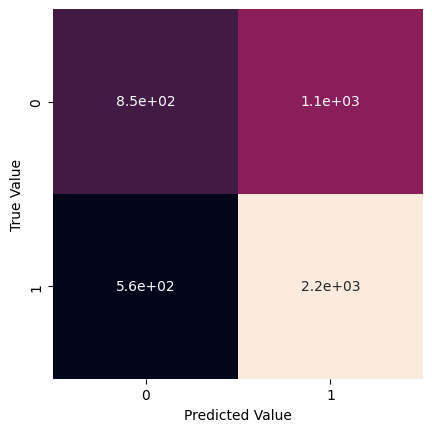

In [262]:
y_pred = knn.predict(X_test)
mat1 = confusion_matrix(y_test, y_pred)
sns.heatmap(mat1, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')

The confusion matrix looks kinda weird...

In [263]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50      1994
           1       0.66      0.80      0.72      2798

    accuracy                           0.64      4792
   macro avg       0.63      0.61      0.61      4792
weighted avg       0.64      0.64      0.63      4792



Wow a 0.26 accuracy! maybe we can try different values of k to see if we can do better.

In [264]:
error_rate = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i*10)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

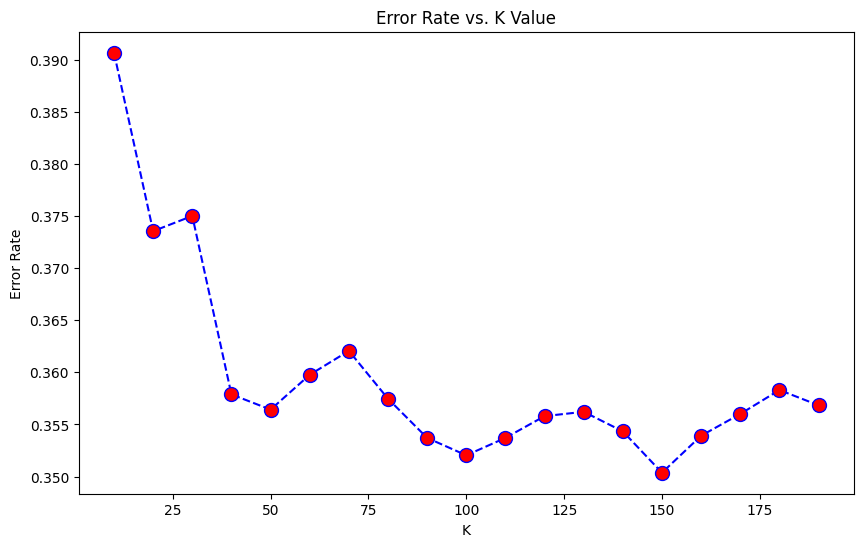

In [265]:
plt.figure(figsize=(10,6))
plt.plot(range(10,200,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

On the bright side we can pretty accurately predict what isn't their stress level?

Let's try a different model! How about neural networks.

In [266]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5),max_iter=10000,learning_rate_init=0.001,activation='tanh')
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52      1994
           1       0.67      0.79      0.72      2798

    accuracy                           0.65      4792
   macro avg       0.64      0.62      0.62      4792
weighted avg       0.64      0.65      0.64      4792



Wow what a difference! perfect accuracy!

Text(113.9222222222222, 0.5, 'True Value')

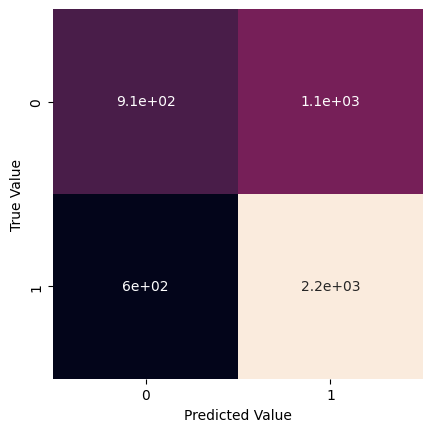

In [267]:
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')